In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as model
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Data Preparation

### Create dataset

In [3]:
# Create datasets

dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/Alzheimers-Detection/data/Dementia')
no_dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/Alzheimers-Detection/data/No_Dementia')

patient_ids = []
class_labels = []
image_paths = []
prefix = '/data/Dementia/'

for path in dementia_image_paths:
    patient_ids.append(path.split('_')[1])
    image_paths.append(prefix + path)
    class_labels.append(1)

prefix = '/data/No_Dementia/' 
for path in no_dementia_image_paths:
    patient_ids.append(path.split('_')[1])
    image_paths.append(prefix + path)
    class_labels.append(0)

df = pd.DataFrame([patient_ids, image_paths, class_labels]).transpose()
df.columns = ['patient_id', 'image_path', 'class_label']
df


,patient_id,image_path,class_label
0,0308,/data/Dementia/OAS1_0308_MR1_mpr-1_125.jpg,1
1,0351,/data/Dementia/OAS1_0351_MR1_mpr-3_112.jpg,1
2,0003,/data/Dementia/OAS1_0003_MR1_mpr-4_145.jpg,1
3,0003,/data/Dementia/OAS1_0003_MR1_mpr-4_151.jpg,1
4,0308,/data/Dementia/OAS1_0308_MR1_mpr-1_131.jpg,1
...,...,...,...
2924,0005,/data/No_Dementia/OAS1_0005_MR1_mpr-3_146.jpg,0
2925,0005,/data/No_Dementia/OAS1_0005_MR1_mpr-3_152.jpg,0
2926,0004,/data/No_Dementia/OAS1_0004_MR1_mpr-3_154.jpg,0
2927,0001,/data/No_Dementia/OAS1_0001_MR1_mpr-2_152.jpg,0


### Train-Test Split (based on random selection of patients done in data_exploration.ipynb)

In [4]:
train_df = df[df['patient_id'].isin(['0351', '0021', '0003', '0308', '0002', '0004', '0006', '0009'])]
train_df = train_df.reset_index()
print(len(train_df))

test_df = df[df['patient_id'].isin(['0028', '0031', '0001', '0005'])]
test_df = test_df.reset_index()
print(len(test_df))

print('Train Ratio: ', (len(train_df) / len(df)))
print('Test Ratio: ', (len(test_df) / len(df)))

1952
976
Train Ratio:  0.6664390576988733
Test Ratio:  0.3332195288494367


# Data Pipeline

### Defining Transforms

In [5]:
# Importing the custom dataset class
from alzheimers_dataset import alzheimers_dataset
import torchvision.transforms as tf

In [6]:
# Simple transforms for baseline model
transforms = tf.Compose([
    tf.Pad([0, 124,]),
    tf.ToTensor(),
    ])

In [7]:
# Create datasets based on custom dataset class
root_dir = '/Users/aatyanth/COGS181/Alzheimers-Detection'

train_image_paths = train_df['image_path'].to_numpy()
train_labels = train_df['class_label'].to_numpy()
train_set = alzheimers_dataset(root_dir=root_dir, image_paths=train_image_paths, labels=train_labels, transform=transforms)
test_image_paths = test_df['image_path'].to_numpy()
test_labels = test_df['class_label'].to_numpy()
test_set = alzheimers_dataset(root_dir=root_dir, image_paths=test_image_paths, labels=train_labels, transform=transforms)

# Set up DataLoaders for train and test set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True, num_workers=2)

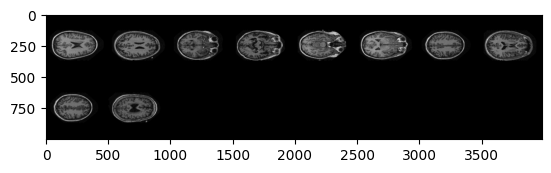

No Alzheimers No Alzheimers No Alzheimers Alzheimers No Alzheimers No Alzheimers No Alzheimers No Alzheimers No Alzheimers Alzheimers


In [8]:
# Test how the images look

# Function to show image
def show_image(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

iteration = iter(train_loader)
images, labels = next(iteration)

show_image(torchvision.utils.make_grid(images))
classes = ("No Alzheimers", "Alzheimers")
print(" ".join('%5s' % classes[labels[j]] for j in range(10)))


# Model Implementation

### Implement ResidualBlock Class

In [10]:
class AlzheimersResNet(nn.Module):
    def __init__(self):
        super(AlzheimersResNet, self).__init__()
        self.model = model.resnet18(pretrained=False)
        